### Etape 1 : Extraction du diagraph à partir du json + Création des 1ères features :

In [2]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import sys
import os

sys.path.append(os.path.abspath(".."))
from src.extract_features import extract_features_from_json, process_json_folder

import dotenv

dotenv.load_dotenv()

False

In [ ]:
train_path = os.environ["TRAIN_PATH"]
data_folder = os.environ["DATA_FOLDER"]

In [3]:
file_name = "0a1e476715aad422601ea1f0184436adef754c57defa816a64258b08a5f8fe48"
json_file = f"{train_path}/{file_name}.json"

df = extract_features_from_json(json_file)
df.transpose()

,0
name,0a1e476715aad422601ea1f0184436adef754c57defa81...
file_size,71995
num_nodes,602
num_edges,605
num_loops,0
num_calls,0
num_jumps,1
num_ret,0
num_conditional_jumps,4
average_out_degree,1.004983


In [4]:
df_features = process_json_folder(train_path, 10)
df_features.head()

Traitement des fichiers JSON: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


,name,file_size,num_nodes,num_edges,num_loops,num_calls,num_jumps,num_ret,num_conditional_jumps,average_out_degree,average_in_degree
0,000288eb820d08011f1f5a379d3ac38e3a4bf679777c2f...,103576,1112,1740,14,270,230,69,428,1.564748,1.564748
1,000299f0baee15daa295b45083f32f0183c25948efdb88...,15984,161,245,4,6,21,4,84,1.521739,1.521739
2,0006f473314630a3a3089e4cf00e34b055d24dc8f82717...,303471,4607,7413,3,2485,641,470,526,1.609073,1.609073
3,00090d289035749bdd0a25ad1990be32b12e3d1ae03bc5...,11229717,102070,182474,65,60104,4938,3941,24487,1.787734,1.787734
4,000a3c574c875d19538eb58a9aca407f3a7db5f7d561b4...,3728521,42349,64677,88,13625,3474,3590,13004,1.527238,1.527238


## EDA

### Target / label : Import

In [5]:
target = pd.read_csv(f"{data_folder}/training_set_metadata.csv", sep=";", index_col=0)

<Axes: >

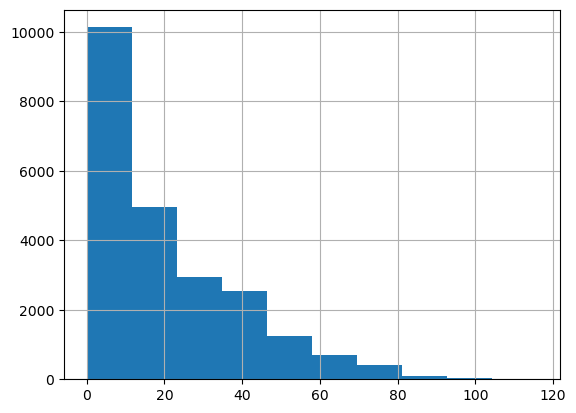

In [6]:
target.T.sum().hist()

In [7]:
target.sum(axis=0).sort_values(ascending=True)

yoda                                 1
sudo                                 1
pklite                               1
stealth                              1
create reverse shell on Linux        1
                                 ...  
detect-debug-environment          9272
write file on Windows            10050
encode data using XOR            10053
overlay                          12166
peexe                            18145
Length: 453, dtype: int64

In [8]:
correlations = target.corr()

Ici l'objectif était de regarder les liens entre les observations à prédire :
- quelles étaient celles qui sont fortement corrélées
- si avoir un 1 à certaines observations impliquait un 1 dans d'autres observations

In [9]:
high_corr_pairs = []

for col1 in correlations.columns:
    for col2 in correlations.columns:
        if col1 != col2:  # Ne pas inclure la diagonale
            if abs(correlations.loc[col1, col2]) > 0.8:
                high_corr_pairs.append((col1, col2, correlations.loc[col1, col2]))

high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Colonne1', 'Colonne2', 'Corrélation'])
high_corr_df.sort_values(by="Corrélation", ascending=False)

,Colonne1,Colonne2,Corrélation
11,decompress data via IEncodingFilterFactory,decompress HTTP response via IEncodingFilterFa...,1.000000
7,checks-hostname,macho,1.000000
19,macho,checks-hostname,1.000000
18,lock file,create reverse shell on Linux,1.000000
10,decompress HTTP response via IEncodingFilterFa...,decompress data via IEncodingFilterFactory,1.000000
9,create reverse shell on Linux,lock file,1.000000
0,android,apk,0.992488
3,apk,android,0.992488
33,send HTTP response,receive HTTP request,0.988002
26,receive HTTP request,send HTTP response,0.988002


In [10]:
def get_implication(value:int=1):
    """
    Objectif de la fonction déduire des implication entre deux comportements
    Si on observe que col1=1 => col2=1 alors (value =1)
        - si on a prédit un 1 à col 1 avec un bon taux de confiance on sait que ce sera un 1 pour col 2
        - par contraposée, si on a prédit un 0 à col2 avec un bon taux de confiance, on sait que ce sera un 0 pour col1
    
    Si on observe que col1=0 => col2=0 alors (value = 0)
        - si on a prédit un 0 à col 1 avec un bon taux de confiance on sait que ce sera un 0 pour col 2
        - par contraposée, si on a prédit un 1 à col2 avec un bon taux de confiance, on sait que ce sera un 1 pour col1
    """
    implications = []

    for col1 in tqdm(target.columns):
        lines = target[(target[col1] == value)].index
        if len(lines) > 1 :
            for col2 in target.columns:
                if col1 != col2:  # Ne pas vérifier une colonne avec elle-même
                    condition = target.loc[lines, col2] == value
                    # Si la condition est toujours vraie, alors col2 est impliquée par col1
                    if condition.all():
                        implications.append((col1, col2, len(lines)))

    return pd.DataFrame(implications, columns=['Colonne1', 'Colonne2', f'nb_{value}'])

In [11]:
implications1 = get_implication(1)
implications0 = get_implication(0)

100%|██████████| 453/453 [09:36<00:00,  1.27s/it]


In [88]:
implications1

,Colonne1,Colonne2,nb_1
0,allocate RW memory,allocate memory,891
1,allocate RWX memory,allocate memory,802
2,anorganix,peexe,5
3,apk,android,66
4,arm,peexe,2
...,...,...,...
627,worm,persistence,2
628,write file on Linux,query environment variable,5
629,write file on Linux,read file on Linux,5
630,xorcrypt,overlay,10


#### Analyse detaillée de la présence des comportements

c:\Users\RAR9\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


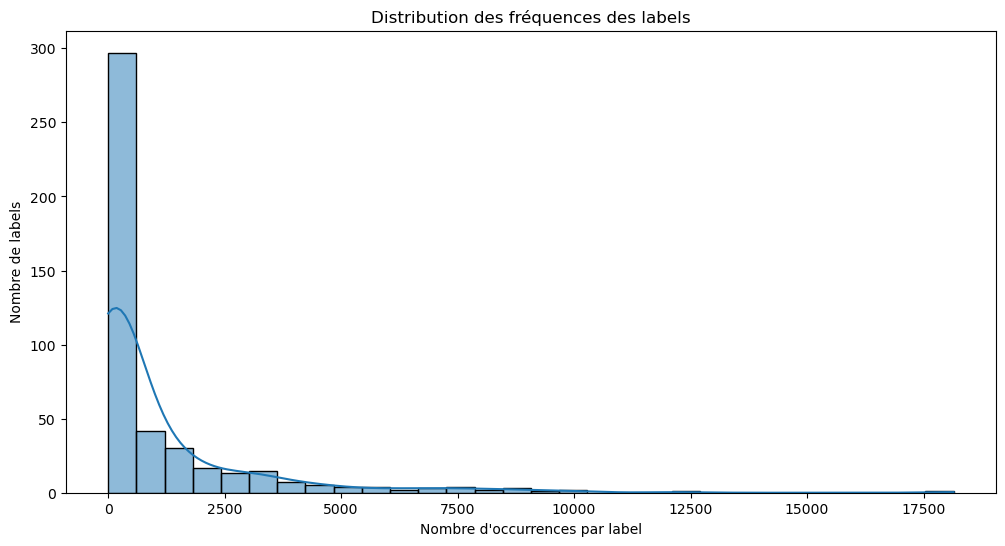


Statistiques sur le nombre de labels par instance :
count    23102.000000
mean        21.104277
std         18.520650
min          0.000000
25%          6.000000
50%         14.000000
75%         31.000000
max        116.000000
Name: num_labels, dtype: float64
Skewness : 1.31
Kurtosis : 1.36
IQR : 25.00


c:\Users\RAR9\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


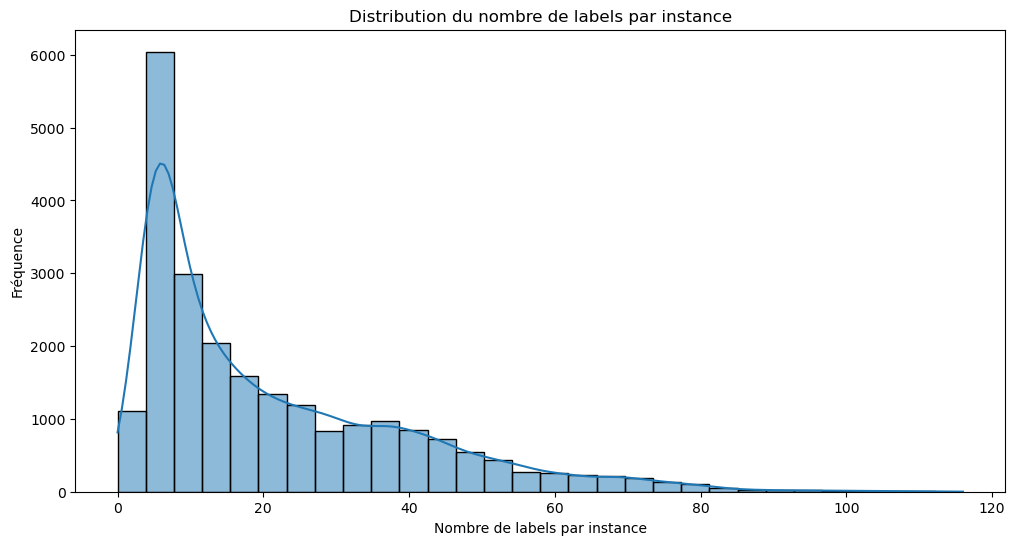

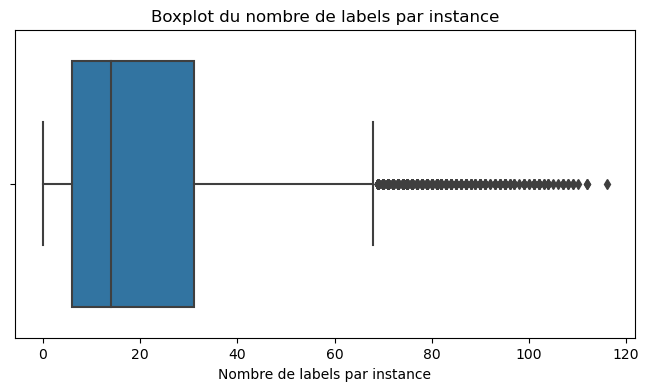

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform

# Identification des labels (colonnes binaires)
label_columns = []
for col in target.columns:
    uniques = set(target[col].dropna().unique())
    if uniques.issubset({0, 1}):
        label_columns.append(col)


# Distribution des fréquences
plt.figure(figsize=(12, 6))
sns.histplot(label_freq, bins=30, kde=True)
plt.title("Distribution des fréquences des labels")
plt.xlabel("Nombre d'occurrences par label")
plt.ylabel("Nombre de labels")
plt.show()

# Analyse du nombre de labels par instance
target['num_labels'] = target[label_columns].sum(axis=1)
num_labels = target['num_labels']
desc = num_labels.describe()
mean_labels = desc['mean']
median_labels = num_labels.median()
std_labels = num_labels.std()
q1 = num_labels.quantile(0.25)
q3 = num_labels.quantile(0.75)
iqr = q3 - q1
skew_labels = skew(num_labels)
kurt_labels = kurtosis(num_labels)

print("\nStatistiques sur le nombre de labels par instance :")
print(desc)
print(f"Skewness : {skew_labels:.2f}")
print(f"Kurtosis : {kurt_labels:.2f}")
print(f"IQR : {iqr:.2f}")

plt.figure(figsize=(12, 6))
sns.histplot(num_labels, bins=30, kde=True)
plt.title("Distribution du nombre de labels par instance")
plt.xlabel("Nombre de labels par instance")
plt.ylabel("Fréquence")
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(x=num_labels)
plt.title("Boxplot du nombre de labels par instance")
plt.xlabel("Nombre de labels par instance")
plt.show()




#### Analyse approfondie des relations entre comportements par distance de corrélation



#### Variance expliquée par les vecteurs de corrélation avec une PCA

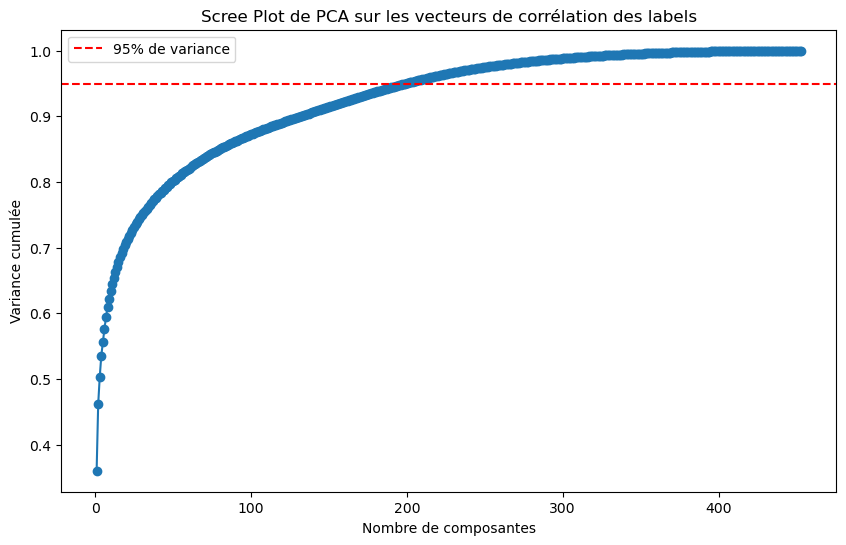

In [25]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

corr_matrix = target[label_columns].corr()
corr_vectors = corr_matrix.values

pca = PCA()
pca.fit(corr_vectors)

# Variance cumulée
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(explained_variance)+1), explained_variance, marker='o')
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance cumulée')
plt.title('Scree Plot de PCA sur les vecteurs de corrélation des labels')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% de variance')
plt.legend()
plt.show()


#### Projection en 3D des composantes principales des ocmportements avec PCA combinée à une visualisation PACMAP et HDBSCAN 

In [32]:
import pandas as pd
import numpy as np
import pacmap
import hdbscan
import plotly.express as px
from sklearn.decomposition import PCA

# Première étape : Réduction par PCA à 100 composantes
pca = PCA(n_components=200, random_state=42)
pca_embedding = pca.fit_transform(corr_vectors)

# Deuxième étape : Réduction à 3 dimensions avec PaCMAP pour une visualisation 3D
pacmap_reducer = pacmap.PaCMAP(n_components=3, n_neighbors=30, MN_ratio=0.8, FP_ratio=1.0, random_state=42)
final_embedding = pacmap_reducer.fit_transform(pca_embedding)

# Clustering : Utilisation de HDBSCAN pour détecter automatiquement des clusters
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean')
clusters = clusterer.fit_predict(final_embedding)

viz_df = pd.DataFrame({
    'label': corr_matrix.columns,
    'PC1': final_embedding[:, 0],
    'PC2': final_embedding[:, 1],
    'PC3': final_embedding[:, 2],
    'cluster': clusters,
    'frequency': target[label_columns].sum()  # Fréquence d'apparition de chaque label
})

# Calcul de la taille moyenne des clusters (en excluant le bruit, identifié par cluster == -1)
valid_clusters = viz_df[viz_df['cluster'] != -1]
if not valid_clusters.empty:
    cluster_sizes = valid_clusters.groupby('cluster').size()
    avg_cluster_size = cluster_sizes.mean()
else:
    avg_cluster_size = 0

print("Nombre de clusters (excluant le bruit) :", valid_clusters['cluster'].nunique())
print("Taille moyenne des clusters (excluant le bruit) :", avg_cluster_size)

# Visualisation interactive 3D avec Plotly Express
fig = px.scatter_3d(
    viz_df,
    x='PC1', y='PC2', z='PC3',
    color='cluster',
    size='frequency',
    hover_name='label',
    title='Projection 3D après PCA à 200 composantes combinée avec PaCMAP et HDBSCAN',
)
fig.update_traces(marker=dict(line=dict(width=0.5, color='DarkSlateGrey')))
fig.show()


Note: `n_components != 2` have not been thoroughly tested.


Nombre de clusters (excluant le bruit) : 7
Taille moyenne des clusters (excluant le bruit) : 43.142857142857146


c:\Users\RAR9\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\RAR9\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



#### Projection en 3D des comportements avec PACMAP et HDBSCAN (sans PCA)

In [24]:
import pandas as pd
import numpy as np
import pacmap
import hdbscan
import plotly.express as px


# Réduction de dimension à 3D avec PaCMAP
# On choisit n_neighbors=30, MN_ratio=0.8, FP_ratio=1.0 pour favoriser une structure globale
pacmap_reducer = pacmap.PaCMAP(n_components=3, n_neighbors=30, MN_ratio=0.8, FP_ratio=1.0, random_state=42)
embedding = pacmap_reducer.fit_transform(corr_vectors)

# Clustering avec HDBSCAN pour détecter des clusters (min_cluster_size=10 pour obtenir des clusters robustes)
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean')
clusters = clusterer.fit_predict(embedding)

# Préparer un DataFrame pour la visualisation avec Plotly
viz_df = pd.DataFrame({
    'label': corr_matrix.columns,
    'PC1': embedding[:, 0],
    'PC2': embedding[:, 1],
    'PC3': embedding[:, 2],
    'cluster': clusters,
    'frequency': target[label_columns].sum()  # fréquence d'apparition de chaque label
})

# Calcul de la taille moyenne des clusters (excluant le bruit, identifié par cluster == -1)
valid_clusters = viz_df[viz_df['cluster'] != -1]
if not valid_clusters.empty:
    cluster_sizes = valid_clusters.groupby('cluster').size()
    avg_cluster_size = cluster_sizes.mean()
else:
    avg_cluster_size = 0

print("Nombre de clusters (excluant le bruit):", valid_clusters['cluster'].nunique())
print("Taille moyenne des clusters (excluant le bruit):", avg_cluster_size)

# Visualisation interactive 3D avec Plotly Express
fig = px.scatter_3d(
    viz_df,
    x='PC1', y='PC2', z='PC3',
    color='cluster',
    size='frequency',
    hover_name='label',
    title='Projection 3D des vecteurs de corrélation des labels\n' +
          f'Clusters détectés par HDBSCAN (Taille moyenne ≈ {avg_cluster_size:.2f})',
    color_continuous_scale='Viridis'
)

fig.update_traces(marker=dict(line=dict(width=0.5, color='DarkSlateGrey')))
fig.show()


Note: `n_components != 2` have not been thoroughly tested.
c:\Users\RAR9\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\RAR9\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Nombre de clusters (excluant le bruit): 7
Taille moyenne des clusters (excluant le bruit): 51.714285714285715


#### Interprétation :
#### Si la taille moyenne des clusters est très faible, cela signifie que les labels ne co-occurrents pas en groupes importants.

#### Pour un algorithme de classification se basant sur des espaces de labels, comme RAKEL, il peut être intéressant de se baser sur la distribution des labels par instance et prendre en compte la petite taille des clusters.
